# Create Knowledge Bases for Amazon Bedrock to decide RIGHT Chuncking Size based on your dataset for optimizing RAG application

This notebook provides sample code for building multiple knowledge bases for Amazon Bedrock based on different chunk sizes.

Repeat the following steps for each chunk size (you want to evaluate):

- Create execution role for Knowledge Bases for Amazon Bedrock with necessary policies for accessing data from S3 and writing embeddings into vector store (OpenSearchServerless).
- Create an empty OpenSearch serverless index.
- Download documents (or point to your document S3 location)
- Create knowledge base for Amazon Bedrock 
- Create a data source within knowledge base which will connect to Amazon S3
- Once the data is available in the Bedrock Knowledge Bases with different chunk size, we'll evaluate the text chunks retreived for refernce QA pairs from these knowledge bases for faithfulness, correctness, and relevancy metrics using LlamaIndex. 
- Using these metrics we can decide for RIGHT chunk size for our RAG based application. 

Finally, based on the evaluation results, a question answering application with RIGHT chunk strategy can be built using the Amazon Bedrock APIs.  

## Usecase
### Dataset
In this example, you will use several years of Amazon's Letter to Shareholders as a text corpus to perform Q&A on.

## Setup 
Before running the rest of this notebook, you'll need to run the cells below to (ensure necessary libraries are installed and) connect to Bedrock.

<div class="alert alert-block alert-warning">
<b>Warning:</b> Please ignore error messages related to pip's dependency resolver.
</div>

In [41]:
%pip install --upgrade pip
%pip install boto3==1.33.2 --force-reinstall --quiet
%pip install botocore==1.33.2 --force-reinstall --quiet
%pip install -U opensearch-py==2.3.1
%pip install -U retrying==1.3.4

%pip install langchain==0.0.342 --force-reinstall --quiet
%pip install llama-index==0.9.3.post1 --force-reinstall --quiet

Note: you may need to restart the kernel to use updated packages.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.50.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
awscli 1.32.49 requires botocore==1.34.49, but you have botocore 1.33.13 which is incompatible.
awscli 1.32.49 requires s3transfer<0.11.0,>=0.10.0, but you have s3transfer 0.8.2 which is incompatible.
llama-index 0.9.3.post1 requires urllib3<2, but you have urllib3 2.0.7 which is incompatible.
opensearch-py 2.3.1 requires urllib3<2,>=1.21.1, but you have urllib3 2.0.7 which is incompatible.
primeqa 0.15.2 requires click~=8.0.4, but you have click 8.1.7 which is incompatible.
primeqa 0.15.2 requires fastapi~=0.85.0, but you have fastapi 0.100.1 which is incompatible.
primeqa 0.15.2 requires grpcio~=1.48.1, but you have grpcio 1.53.0 which is incompatib

In [42]:
# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [43]:
import warnings
warnings.filterwarnings('ignore')

In [44]:
import nest_asyncio
nest_asyncio.apply()

In [45]:
import json
import os
import sys
import time
import boto3
import pandas as pd
import random
from retrying import retry

import pprint
pp = pprint.PrettyPrinter(indent=2)

In [46]:
module_path = ".."
sys.path.append(os.path.abspath(module_path))

from utility import create_bedrock_execution_role, create_oss_policy_attach_bedrock_execution_role, create_policies_in_oss

In [47]:
# getting boto3 clients for required AWS services
sts_client = boto3.client('sts')
iam_client = boto3.client('iam')
s3_client = boto3.client("s3")
bedrock_runtime_client = boto3.client('bedrock-runtime')
bedrock_agent_client = boto3.client('bedrock-agent')
bedrock_agent_runtime_client = boto3.client('bedrock-agent-runtime')
aoss_client = boto3.client('opensearchserverless')

In [48]:
session = boto3.session.Session()
region_name = session.region_name
account_id = sts_client.get_caller_identity()["Account"]
region_name, account_id

('us-east-1', '017444429555')

In [49]:
# Generate random suffix for unique vector store, vector index, and KB name
suffix = random.randrange(200, 900)
# Bucket name  and prefix for KB files 
bucket_name = f"chunk-evaluation-{region_name}-{account_id}" # replace it with your bucket name.
s3_prefix = 'shareholder-letters'

# Create S3 bucket for uploading the data
s3bucket = s3_client.create_bucket(Bucket=bucket_name)

## Step 1 - Create a vector store - OpenSearch Serverless index

### Create OSS policies and collection
First of all we have to create a vector store. In this section we will use *Amazon OpenSerach serverless.*

Amazon OpenSearch Serverless is a serverless option in Amazon OpenSearch Service. As a developer, you can use OpenSearch Serverless to run petabyte-scale workloads without configuring, managing, and scaling OpenSearch clusters. You get the same interactive millisecond response times as OpenSearch Service with the simplicity of a serverless environment. Pay only for what you use by automatically scaling resources to provide the right amount of capacity for your application—without impacting data ingestion.

In [50]:
vector_store_name = f'bedrock-sample-rag-{suffix}'
base_index_name = f"bedrock-sample-rag-index-{suffix}"

# create IAM role
bedrock_kb_execution_role = create_bedrock_execution_role(bucket_name=bucket_name)
bedrock_kb_execution_role_name = bedrock_kb_execution_role['Role']['RoleName']
bedrock_kb_execution_role_arn = bedrock_kb_execution_role['Role']['Arn']

In [51]:
bedrock_kb_execution_role_name

'AmazonBedrockExecutionRoleForKnowledgeBase_759'

In [52]:
# create security, network and data access policies within OSS
encryption_policy, network_policy, access_policy = create_policies_in_oss(vector_store_name=vector_store_name,
                       aoss_client=aoss_client,
                       bedrock_kb_execution_role_arn=bedrock_kb_execution_role_arn)
collection = aoss_client.create_collection(name=vector_store_name,type='VECTORSEARCH')

In [53]:
pp.pprint(collection)
time.sleep(10)

{ 'ResponseMetadata': { 'HTTPHeaders': { 'connection': 'keep-alive',
                                         'content-length': '312',
                                         'content-type': 'application/x-amz-json-1.0',
                                         'date': 'Tue, 05 Mar 2024 19:58:17 '
                                                 'GMT',
                                         'x-amzn-requestid': '12217fe3-10e3-4924-83c3-51769150d1de'},
                        'HTTPStatusCode': 200,
                        'RequestId': '12217fe3-10e3-4924-83c3-51769150d1de',
                        'RetryAttempts': 0},
  'createCollectionDetail': { 'arn': 'arn:aws:aoss:us-east-1:017444429555:collection/mfivuhtfc0ib6yl6nil',
                              'createdDate': 1709668697679,
                              'id': 'mfivuhtfc0ib6yl6nil',
                              'kmsKeyArn': 'auto',
                              'lastModifiedDate': 1709668697679,
                              '

In [54]:
collection_id = collection['createCollectionDetail']['id']
host = collection_id + '.' + region_name + '.aoss.amazonaws.com'
print(host)

mfivuhtfc0ib6yl6nil.us-east-1.aoss.amazonaws.com


In [55]:
# create oss policy and attach it to Bedrock execution role
create_oss_policy_attach_bedrock_execution_role(collection_id=collection_id,
                                                bedrock_kb_execution_role=bedrock_kb_execution_role)

Opensearch serverless arn:  arn:aws:iam::017444429555:policy/AmazonBedrockOSSPolicyForKnowledgeBase_759


## Step 2 -  Download data

In [56]:
# Download and prepare dataset
!mkdir -p ./data

from urllib.request import urlretrieve
urls = [
    'https://s2.q4cdn.com/299287126/files/doc_financials/2023/ar/2022-Shareholder-Letter.pdf',
    'https://s2.q4cdn.com/299287126/files/doc_financials/2022/ar/2021-Shareholder-Letter.pdf',
    'https://s2.q4cdn.com/299287126/files/doc_financials/2021/ar/Amazon-2020-Shareholder-Letter-and-1997-Shareholder-Letter.pdf',
    'https://s2.q4cdn.com/299287126/files/doc_financials/2020/ar/2019-Shareholder-Letter.pdf'
]

filenames = [
    'AMZN-2022-Shareholder-Letter.pdf',
    'AMZN-2021-Shareholder-Letter.pdf',
    'AMZN-2020-Shareholder-Letter.pdf',
    'AMZN-2019-Shareholder-Letter.pdf'
]

data_root = "./data/"

for idx, url in enumerate(urls):
    file_path = data_root + filenames[idx]
    urlretrieve(url, file_path)


### Upload the data to S3

In [57]:
# Upload data to s3 in a prefix
def uploadDirectory(path,bucket_name):
        for root,dirs,files in os.walk(path):
            for file in files:
                s3_client.upload_file(os.path.join(root,file), bucket_name, s3_prefix + '/' + file)

uploadDirectory(data_root, bucket_name)

## Step 3 - Chunking Evaluation Setup

### OSS Configurations
We'll set-up multiple KBs with various chunk sizes, and create multiple vector indexes for storing Embeddings for corresponding chunk sizes

In [58]:
from opensearchpy import OpenSearch, RequestsHttpConnection, AWSV4SignerAuth
from requests_aws4auth import AWS4Auth

service = 'aoss'
credentials = boto3.Session().get_credentials()
awsauth = AWSV4SignerAuth(credentials, region_name, service)


body_json = {
   "settings": {
      "index.knn": "true"
   },
   "mappings": {
      "properties": {
         "vector": {
            "type": "knn_vector",
            "dimension": 1536
         },
         "text": {
            "type": "text"
         },
         "text-metadata": {
            "type": "text"         }
      }
   }
}
# Build the OpenSearch client
oss_client = OpenSearch(
    hosts=[{'host': host, 'port': 443}],
    http_auth=awsauth,
    use_ssl=True,
    verify_certs=True,
    connection_class=RequestsHttpConnection,
    timeout=300
)
# # It can take up to a minute for data access rules to be enforced
time.sleep(60)

### Knowledge Base Configurations
Steps:
- initialize Open search serverless configuration which will include collection ARN, index name, vector field, text field and metadata field.
- initialize chunking strategy, based on which KB will split the documents into pieces of size equal to the chunk size mentioned in the `chunkingStrategyConfiguration`.
- initialize the s3 configuration, which will be used to create the data source object later.
- initialize the Titan embeddings model ARN, as this will be used to create the embeddings for each of the text chunks.

In [59]:
opensearchServerlessConfiguration = {
            "collectionArn": collection["createCollectionDetail"]['arn'],
            "vectorIndexName": base_index_name,
            "fieldMapping": {
                "vectorField": "vector",
                "textField": "text",
                "metadataField": "text-metadata"
            }
        }

chunkingStrategyConfiguration = {
    "chunkingStrategy": "FIXED_SIZE",
    "fixedSizeChunkingConfiguration": {
        "maxTokens": 512,
        "overlapPercentage": 20
    }
}

s3Configuration = {
    "bucketArn": f"arn:aws:s3:::{bucket_name}",
    "inclusionPrefixes":[s3_prefix] # you can use this if you want to create a KB using data within s3 prefixes.
}

embeddingModelArn = f"arn:aws:bedrock:{region_name}::foundation-model/amazon.titan-embed-text-v1"

name = f"bedrock-sample-knowledge-base-{suffix}"
description = "Amazon shareholder letter knowledge base."
roleArn = bedrock_kb_execution_role_arn


We'll use these configurations as input to the `create_e2e_kb` method (defined below), which will set-up the end-to-end Knowledge base.

## Step 4 -  Create seperate Knowledge base for each chunk size

Create separate Knowledge base for each chunk size. This function will create e2e Knowledge base by following following steps:

- Create Knowledge bases and OpenSearchServerless collection/index based on the input configuration
- Create Datasource for each Knowledge base
- Create Ingestion Job for ingesting data into each Knowledge base

In [60]:
# Function to setup end-to-end knowledge base as mentioned above

def create_e2e_kb(kb_name, kb_description, bucket_name, chunk_size, overlapPercentage, oss_client, base_index_name):
    
    index_name = base_index_name + '-' + str(chunk_size)
    response = oss_client.indices.create(index=index_name, body=json.dumps(body_json))
    time.sleep(20)
    
    # Set the parameters value
    opensearchServerlessConfiguration['vectorIndexName'] = index_name
    chunkingStrategyConfiguration['fixedSizeChunkingConfiguration']['maxTokens']= chunk_size
    chunkingStrategyConfiguration['fixedSizeChunkingConfiguration']['overlapPercentage']= overlapPercentage
    
   
    kb_name = f"{kb_name}-{suffix}-{chunk_size}"
    description = f"{kb_description}-{chunk_size}"
    
    # Create a KnowledgeBase
    kb_response=''
    
    try:
        # @retry(wait_random_min=1000, wait_random_max=2000,stop_max_attempt_number=7)
        create_kb_response = bedrock_agent_client.create_knowledge_base(
                name = kb_name,
                description = description,
                roleArn = roleArn,
                knowledgeBaseConfiguration = {
                    "type": "VECTOR",
                    "vectorKnowledgeBaseConfiguration": {
                        "embeddingModelArn": embeddingModelArn
                    }
                },
                storageConfiguration = {
                    "type": "OPENSEARCH_SERVERLESS",
                    "opensearchServerlessConfiguration":opensearchServerlessConfiguration
                }
            )

        kb_response= create_kb_response["knowledgeBase"]
        # Get KnowledgeBase 
        print(f"KB ID: {kb_response['knowledgeBaseId']} KB Name: {kb_response['name']}")

    except Exception as err:
        print(f"{err=}, {type(err)=}")
    
    # Get KnowledgeBase 
    get_kb_response = bedrock_agent_client.get_knowledge_base(knowledgeBaseId = kb_response['knowledgeBaseId'])
        
    # Create a DataSource in KnowledgeBase 
    create_ds_response = bedrock_agent_client.create_data_source(
        name = kb_name,
        description = description,
        knowledgeBaseId = kb_response['knowledgeBaseId'],
        dataSourceConfiguration = {
            "type": "S3",
            "s3Configuration":s3Configuration
        },
        vectorIngestionConfiguration = {
            "chunkingConfiguration": chunkingStrategyConfiguration
        }
    )
    ds = create_ds_response["dataSource"]
    
    # Get DataSource 
    bedrock_agent_client.get_data_source(knowledgeBaseId = kb_response['knowledgeBaseId'], dataSourceId = ds["dataSourceId"])
    
    # Start an ingestion job
    start_job_response = bedrock_agent_client.start_ingestion_job(knowledgeBaseId = kb_response['knowledgeBaseId'], dataSourceId = ds["dataSourceId"])
    job = start_job_response["ingestionJob"]
 
    kb_id = kb_response["knowledgeBaseId"]
    
    return kb_name, kb_id, index_name, job
   

In [61]:
%%time

# Define variables for creating KnowledgeBase

base_kb_name = f"amazon-shareholder-letters-knowledge-base"
kb_description = "Amazon shareholder letter knowledge base."
overlapPercentage = 20

kb_oss_index_dict={}
job_list =[]

# Define chunksize you want to evaluate
chunkSizes = [300, 512, 700]
data = []

# Create KB for each chunk size
for chunk_size in chunkSizes:
    kb_name, kb_id, index_name, job = create_e2e_kb(base_kb_name, kb_description, bucket_name, chunk_size, overlapPercentage, oss_client, base_index_name)
    kb_oss_index_dict[chunk_size] = {'kb_id':kb_id, 'kb_name':kb_name, 'index_name':index_name}
    job_list.append(job)

KB ID: MULPGDRDQZ KB Name: amazon-shareholder-letters-knowledge-base-699-300
KB ID: EYKWHFDT9R KB Name: amazon-shareholder-letters-knowledge-base-699-512
KB ID: Z3FLLRDBYF KB Name: amazon-shareholder-letters-knowledge-base-699-700
CPU times: user 61.5 ms, sys: 6.46 ms, total: 67.9 ms
Wall time: 1min 7s


In [62]:
job_list

[{'knowledgeBaseId': 'MULPGDRDQZ',
  'dataSourceId': 'PQCRNN189I',
  'ingestionJobId': '9PULPGWYMN',
  'status': 'STARTING',
  'statistics': {'numberOfDocumentsScanned': 0,
   'numberOfNewDocumentsIndexed': 0,
   'numberOfModifiedDocumentsIndexed': 0,
   'numberOfDocumentsDeleted': 0,
   'numberOfDocumentsFailed': 0},
  'startedAt': datetime.datetime(2024, 3, 5, 19, 59, 55, 666655, tzinfo=tzutc()),
  'updatedAt': datetime.datetime(2024, 3, 5, 19, 59, 55, 666655, tzinfo=tzutc())},
 {'knowledgeBaseId': 'EYKWHFDT9R',
  'dataSourceId': '1FYVVT31AB',
  'ingestionJobId': 'TUWBFKKXRA',
  'status': 'STARTING',
  'statistics': {'numberOfDocumentsScanned': 0,
   'numberOfNewDocumentsIndexed': 0,
   'numberOfModifiedDocumentsIndexed': 0,
   'numberOfDocumentsDeleted': 0,
   'numberOfDocumentsFailed': 0},
  'startedAt': datetime.datetime(2024, 3, 5, 20, 0, 17, 338204, tzinfo=tzutc()),
  'updatedAt': datetime.datetime(2024, 3, 5, 20, 0, 17, 338204, tzinfo=tzutc())},
 {'knowledgeBaseId': 'Z3FLLRDBYF

In [63]:
# Wait while Ingestion job is running
# Get job status
for job in job_list:
    while(job['status']!='COMPLETE' ):
        get_job_response = bedrock_agent_client.get_ingestion_job(
          knowledgeBaseId = job_list[-1]['knowledgeBaseId'],
            dataSourceId = job_list[-1]["dataSourceId"],
            ingestionJobId = job_list[-1]["ingestionJobId"]
          )
        job = get_job_response["ingestionJob"]
        time.sleep(10)
    # pp.pprint(job)
    # time.sleep(40)

In [64]:
pp.pprint(kb_oss_index_dict)

{ 300: { 'index_name': 'bedrock-sample-rag-index-699-300',
         'kb_id': 'MULPGDRDQZ',
         'kb_name': 'amazon-shareholder-letters-knowledge-base-699-300'},
  512: { 'index_name': 'bedrock-sample-rag-index-699-512',
         'kb_id': 'EYKWHFDT9R',
         'kb_name': 'amazon-shareholder-letters-knowledge-base-699-512'},
  700: { 'index_name': 'bedrock-sample-rag-index-699-700',
         'kb_id': 'Z3FLLRDBYF',
         'kb_name': 'amazon-shareholder-letters-knowledge-base-699-700'}}


Let's store kb_oss_index_dict, so we can retrieve it while CleanUp

In [65]:
%store kb_oss_index_dict

Stored 'kb_oss_index_dict' (dict)


## Step 5 - Chunking evaluation setup

    - Define Retrieve function - to get text chunks
    - Define Prompt template specific to the model
    - Define Refernce QA pair
    - Define function to evaluate text chunks for faithfulness, correctness, and relevancy metrics

### Retrieve functions that calls Retrieve API

Define a retrieve function that calls the `Retreive API` provided by Knowledge bases for Amazon Bedrock which converts user queries into
embeddings, searches the knowledge base, and returns the relevant results, giving you more control to build custom
workﬂows on top of the semantic search results. The output of the `Retrieve API` includes the the `retrieved text chunks`, the `location type` and `URI` of the source data, as well as the relevance `scores` of the retrievals. 

In [66]:
def retrieve(query, kbId, numberOfResults=5):
    return bedrock_agent_runtime_client.retrieve(
        retrievalQuery= {
            'text': query
        },
        knowledgeBaseId=kbId,
        retrievalConfiguration= {
            'vectorSearchConfiguration': {
                'numberOfResults': numberOfResults
            }
        }
    )

### Prompt template - specific to the model to personalize responses 

Here, we will use the specific prompt below for the model to act as a financial advisor AI system that will provide answers to questions by using fact based and statistical information when possible. We will provide the `Retrieve API` responses from above as a part of the `{context_str}` in the prompt for the model to refer to, along with the user `query`.  

In [67]:
from langchain.prompts import PromptTemplate

PROMPT_TEMPLATE = """
You are a financial advisor AI system, and provides answers to questions by using fact based and statistical information when possible. 
Use the following pieces of information to provide a concise answer to the question enclosed in <question> tags. 
If you don't know the answer, just say that you don't know, don't try to make up an answer.
<context>
{context_str}
</context>

<question>
{query_str}
</question>

The response should be specific and use statistics or numbers when possible.
"""
titan_prompt = PromptTemplate(template=PROMPT_TEMPLATE, 
                               input_variables=["context_str","query_str"])

### Function to fetch the text chunks from the RetrieveAPI response

In [68]:
# fetch context from the response
def get_contexts(retrievalResults):
    contexts = []
    for retrievedResult in retrievalResults: 
        contexts.append(retrievedResult['content']['text'])
    return contexts

### Reference QA pair

In [69]:
eval_question_answer_pair = [("How many days has Amazon asked employees to come to work in office?",
                          "Amazon has asked corporate employees to come back to office at least three days a week beginning May 2022."),
                         ("By what percentage did AWS revenue grow year-over-year in 2022?",
                          "AWS had a 29% year-over-year ('YoY') revenue in 2022 on $62B revenue base."),
                         ("Compared to Graviton2 processors, what performance improvement did Graviton3 chips deliver according to the passage?",
                          "In 2022, AWS delivered their Graviton3 chips, providing 25% better performance than the Graviton2 processors."),
                         ("Which was the first inference chip launched by AWS according to the passage?",
                          "AWS launched their first inference chips (“Inferentia”) in 2019, and they have saved companies like Amazon over a hundred million dollars in capital expense."),
                         ("According to the context, in what year did Amazon's annual revenue increase from $245B to $434B?",
                          "Amazon's annual revenue increased from $245B in 2019 to $434B in 2022."
                          )
                          ]

## Step 6 - Evaluate Chunk size for RAG workflow

For our evaluation, we will use the Retreive API provided by Knowledge bases for Amazon Bedrock which converts user queries into embeddings, searches the knowledge base, and returns the relevant results, giving you more control to build custom workﬂows on top of the semantic search results. The output of the Retrieve API includes the the retrieved text chunks, the location type and URI of the source data, as well as the scores of the retrievals.

Next, we'll evaluate the relevancy of text chunks corresponding to the original prompt using LLaMaIndex relevancy metrics, and compare it against a threshold value.

- if relevancy score for retreived text chunks doesn't pass the threshold, then original prompt won't be passed to large language model (LLM) to generate the response.
    
- otherwise, we will use the text chunks being generated and augment it with the original prompt and pass it through the LLM using prompt engineering patterns.

        - Finally we will evaluate the generated responses using metrics such as faithfulness, correctness, and relevancy metrics. For evaluation, we will use Anthropic Claude v2 model, and for response generation we'll use amazon.titan-text-express-v1 model.

In [84]:
from llama_index.llms import LangChainLLM
from langchain.llms import Bedrock
from llama_index.embeddings import LangchainEmbedding
from langchain.embeddings import BedrockEmbeddings
from llama_index.evaluation import RelevancyEvaluator, FaithfulnessEvaluator, CorrectnessEvaluator
from llama_index import SimpleDirectoryReader, VectorStoreIndex, ServiceContext, set_global_service_context

def evaluate_chunk_size_kb(chunk_size, qa_pairs, kb_id, vector_index, relevancy_threshold):
    """
    Evaluate the average response time, faithfulness, and relevancy of responses generated by amazon.titan-text-lite-v1 for a given chunk size.
    We'll use 'amazon.titan-embed-text-v1' for embedding and 'anthropic.claude-v2' to evaluate the response
    
    Parameters:
    chunk_size (int): The size of data chunks being processed.
    qa_pairs (list): List of QA tuples
    kb_id (str) : KnowledgeBase ID under evaluation
    vector_index (str): vector index associated with KnowledgeBase
    relevancy_threshold (float) : Threshold value for Relevancy
    
    Returns:
    tuple: A tuple containing the average response time, faithfulness, and relevancy metrics.
    """
    bedrock_client = boto3.client('bedrock-runtime')
    
    # Configurations
    llm_parameters = {
    "maxTokenCount":2000,
    "stopSequences":[],
    "temperature":0,
    "topP":0.9
    }

    model_kwargs_claude = {
        "temperature": 0,
        "top_k": 10,
        "max_tokens_to_sample": 3000
    }

   
    # 1. define bedrock model to generate and evaluate the responses
    llm = Bedrock(model_id = "amazon.titan-text-express-v1",
              model_kwargs=llm_parameters,
              client = bedrock_runtime_client,)
    
    # 2. define bedrock model to evaluate the responses
    llm_claude = Bedrock(model_id = "anthropic.claude-v2",
              model_kwargs=model_kwargs_claude,
              client = bedrock_runtime_client,)
    
    # 3. Define the embed model to be used - 
    embed_model = BedrockEmbeddings(model_id='amazon.titan-embed-text-v1')
    
    # Finally, get vector index
    vector_index = vector_index
    kb_id = kb_id
    
    # Establishing evaluators - Pass two parameters llm and embed model in the service context
    serviceContextLLM = ServiceContext.from_defaults(llm = llm_claude, embed_model=embed_model)
    set_global_service_context(service_context)
    faithfulnessLLM = FaithfulnessEvaluator(service_context=serviceContextLLM)
    relevancyLLM = RelevancyEvaluator(service_context=serviceContextLLM)
    CorrectnessLLM = CorrectnessEvaluator(service_context=serviceContextLLM)
    
    
    # Define variables
    relevancy_threshold = relevancy_threshold # Relevancy threshold
    
    total_response_time = 0
    total_faithfulness = 0
    total_relevancy = 0
    total_correctness = []
    
    results_list = []
    
    average_response_time = 0
    average_faithfulness = 0
    average_relevancy = 0
    avereage_correctness = 0
    
    
    # Check for the avg relevancy score
    '''
    If avg relevency score is under 'relevancy_threshold', we won't pass the context to LLM to
    generate the response. This will avoid unneccessary cost for LLM inference.
    '''
    relevancy_score = 0
    avg_relevancy_score = 0
    
    for question, reference_answer in qa_pairs:
        result = retrieve(question, kb_id, 5)
        retrievalResults = result['retrievalResults']
        # get context
        contexts = get_contexts(retrievalResults=retrievalResults)
        relevancy_result = relevancyLLM.evaluate(query=question,
                                                 response=reference_answer, 
                                                  contexts=contexts)
        relevancy_score += relevancy_result.score
     
    avg_relevancy_score = relevancy_score/len(qa_pairs)
      
    eval_qa_num = 0
   
    # if 'avg_relevancy_score' passes the threshold -  then calculate the metrics
    if avg_relevancy_score > relevancy_threshold:
       
        # Iterate over each question in eval_question_answer_pair to compute metrics.
        # While BatchEvalRunner can be used for faster evaluations (see: https://docs.llamaindex.ai/en/latest/examples/evaluation/batch_eval.html),
        for question, reference_answer in qa_pairs:
            print("\t Question:", question)
            
            start_time = time.time()
            # retrieve matching documents
            result = retrieve(question, kb_id, 5)
            retrievalResults = result['retrievalResults']
            contexts = get_contexts(retrievalResults=retrievalResults)
            #call LLM with updated context and question.
            prompt = titan_prompt.format(context_str=contexts, 
                                     query_str=question)
            response_vector = llm(prompt)
            # generated_answer = str(response_vector)
            elapsed_time = time.time() - start_time
            
            
            try:
                
                
                faithfulness_result = faithfulnessLLM.evaluate(query=question,
                                                              response=response_vector, 
                                                              contexts=contexts)

                relevancy_result = relevancyLLM.evaluate(query=question,
                                                              response=response_vector, 
                                                              contexts=contexts)
            
                correctness_result = CorrectnessLLM.evaluate(
                                                            query=question,
                                                            response=response_vector,
                                                            reference=reference_answer)
                
                print(f"\t Eval Result -> elapsed_time: {elapsed_time}, faithfulness: {faithfulness_result.passing}, relevancy:{relevancy_result.score}, correctness: {correctness_result.score}" )
                print("\t Response:", response_vector)
                total_response_time += elapsed_time
                total_faithfulness += faithfulness_result.passing
                total_relevancy += relevancy_result.score
                total_correctness.append(correctness_result.score)
                eval_qa_num += 1      

            except Exception as e:
                print("\tAn error occured while evaluating the question!!!")
                print(e)
                total_response_time += elapsed_time
                total_faithfulness = 0
                total_relevancy = 0
                total_correctness.append(0.0)
                print(f"\t Eval Result -> elapsed_time: {elapsed_time}, faithfulness: err, relevancy: err, correctness: err" )

        # Calculate average metrics
        average_response_time = total_response_time / eval_qa_num
        average_faithfulness = total_faithfulness / eval_qa_num
        average_relevancy = total_relevancy / eval_qa_num
        avereage_correctness = sum(total_correctness)/ eval_qa_num
                      
    # if 'avg_relevancy_score' doesn't passe the threshold -  then don't send to LLM
    else:
        print("\t Avg relevancy score was below threshold, so Context not sent to the LLM")
        average_response_time = 0
        average_faithfulness = 0
        average_relevancy = relevancy_score
        avereage_correctness = 0
        
    
    # metrics_score ={}
    metrics_score = {
                    'average_relevancy' : f'{average_relevancy:.2f}',
                    'avg_response_time' : f'{average_response_time:.2f}',
                    'average_faithfulness' : f'{average_faithfulness:.2f}',
                    'avereage_correctness' : f'{avereage_correctness:.2f}',
                    # 'detail_eval_df': evals_df
                    } 
    print("\t Evaluation result: ", metrics_score)

    return  metrics_score


In [85]:
%%time

chunk_sizes = list(kb_oss_index_dict.keys())
relevancy_threshold = 0.6
data = []

base_kb_name = f"amazon-shareholder-letters-knowledge-base"
base_index_name = f"bedrock-sample-index"

for chunk_size in chunk_sizes[0:3]:
    print("--------------------------------------------------------")
    print(f"Chunk Size - {chunk_size} evaluation : Initiating...")
    print("--------------------------------------------------------")
    print("In progress....")
    kb_id = kb_oss_index_dict[chunk_size]['kb_id']
    vector_index = kb_oss_index_dict[chunk_size]['index_name']
    
    metrics_score= evaluate_chunk_size_kb(chunk_size, eval_question_answer_pair, kb_id, vector_index, relevancy_threshold)
    print(f"Chunk size {chunk_size} - Average Relevancy: {metrics_score['average_relevancy']}, Average Response time: {metrics_score['avg_response_time']}, Average Faithfulness: {metrics_score['average_faithfulness']},  Average Correctness: {metrics_score['avereage_correctness']}")
    data.append({
            'kb_id':kb_id, 
            'vector_index': vector_index,  
            'Chunk Size': chunk_size, 
            'Average Relevancy': metrics_score['average_relevancy'],
            'Average Response Time': metrics_score['avg_response_time'],
            'Average Faithfulness': metrics_score['average_faithfulness'],
            'Average Correctness': metrics_score['avereage_correctness']} )
    print("Done!!\n")
    # detail_eval_df = metrics_score['detail_eval_df']
    time.sleep(20)
# Creating a DataFrame
df = pd.DataFrame(data)
df.head()

--------------------------------------------------------
Chunk Size - 300 evaluation : Initiating...
--------------------------------------------------------
In progress....
	 Question: How many days has Amazon asked employees to come to work in office?
	 Eval Result -> elapsed_time: 1.323112964630127, faithfulness: False, relevancy:0.0, correctness: 2.0
	 Response: 
Two days a week.
	 Question: By what percentage did AWS revenue grow year-over-year in 2022?
	 Eval Result -> elapsed_time: 1.3365061283111572, faithfulness: False, relevancy:1.0, correctness: 3.0
	 Response: 29%
	 Question: Compared to Graviton2 processors, what performance improvement did Graviton3 chips deliver according to the passage?
	 Eval Result -> elapsed_time: 7.602873802185059, faithfulness: False, relevancy:1.0, correctness: 3.0
	 Response: Graviton3 chips, which were introduced in 2020 and offer a 25% improvement on top of Graviton2's relative gains, provide up to 40% better price-performance than the comparab

,kb_id,vector_index,Chunk Size,Average Relevancy,Average Response Time,Average Faithfulness,Average Correctness
0,MULPGDRDQZ,bedrock-sample-rag-index-699-300,300,0.60,3.00,0.20,2.60
1,EYKWHFDT9R,bedrock-sample-rag-index-699-512,512,0.60,2.70,0.00,3.00
2,Z3FLLRDBYF,bedrock-sample-rag-index-699-700,700,0.60,2.29,0.20,2.40


### Visualize the metrics

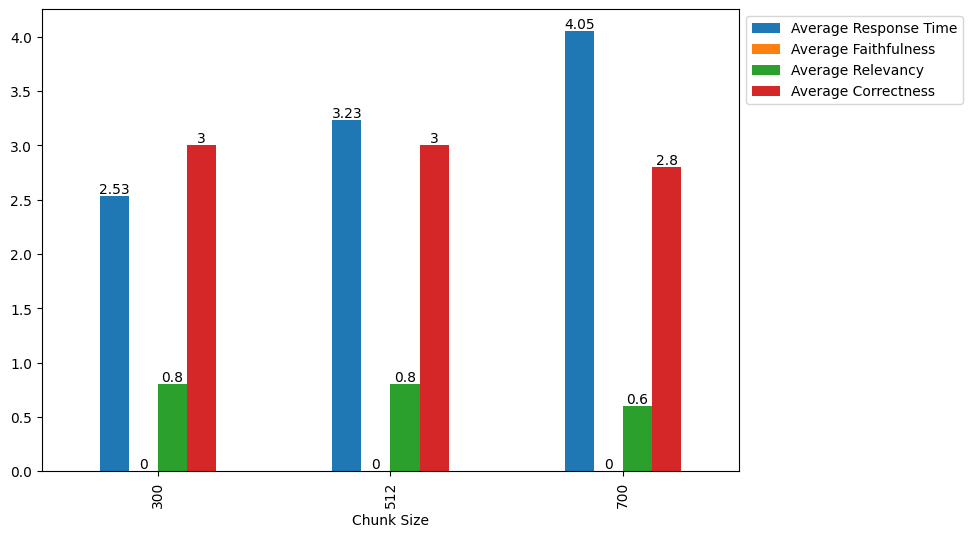

In [73]:
# Convert columns to numeric type
col_to_convert =['Chunk Size', 'Average Response Time','Average Faithfulness', 'Average Relevancy', 'Average Correctness']
df[col_to_convert] = df[col_to_convert].apply(pd.to_numeric)

#Plot metrics
ax = df.plot(
        x='Chunk Size', 
        y=['Average Response Time','Average Faithfulness', 'Average Relevancy', 'Average Correctness'], 
        kind='bar', 
        figsize=(9,6))


ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[2])
ax.bar_label(ax.containers[3])

ax.legend( bbox_to_anchor =(1 ,1))

## Test example

Let's evaluate the response for each chunk size to for a sample query.

In [ ]:
kb_id = kb_oss_index_dict[300]['kb_id']

query = "What is Amazon's doing in the field of generative AI?"

response = retrieve(query, kb_id, 5)
retrievalResults = response['retrievalResults']
# pp.pprint(retrievalResults)
contexts = get_contexts(retrievalResults)

prompt = titan_prompt.format(context_str=contexts, query_str=query)

# Configurations
parameters = {
"maxTokenCount":2000,
"stopSequences":[],
"temperature":0,
"topP":0.9
}

llm = Bedrock(model_id = "amazon.titan-text-lite-v1", model_kwargs=parameters, client = bedrock_runtime_client)
response = llm(prompt)
pp.pprint(response)

In [ ]:
kb_id = kb_oss_index_dict[512]['kb_id']

query = "What is Amazon's doing in the field of generative AI?"

response = retrieve(query, kb_id, 5)
retrievalResults = response['retrievalResults']
# pp.pprint(retrievalResults)
contexts = get_contexts(retrievalResults)

prompt = titan_prompt.format(context_str=contexts, query_str=query)

# Configurations
parameters = {
"maxTokenCount":2000,
"stopSequences":[],
"temperature":0,
"topP":0.9
}

llm = Bedrock(model_id = "amazon.titan-text-lite-v1", model_kwargs=parameters, client = bedrock_runtime_client)
response = llm(prompt)
pp.pprint(response)

In [ ]:
kb_id = kb_oss_index_dict[700]['kb_id']

query = "What is Amazon's doing in the field of generative AI?"

response = retrieve(query, kb_id, 5)
retrievalResults = response['retrievalResults']
# pp.pprint(retrievalResults)
contexts = get_contexts(retrievalResults)

prompt = titan_prompt.format(context_str=contexts, query_str=query)

# Configurations
parameters = {
"maxTokenCount":2000,
"stopSequences":[],
"temperature":0,
"topP":0.9
}

llm = Bedrock(model_id = "amazon.titan-text-lite-v1", model_kwargs=parameters, client = bedrock_runtime_client)
response = llm(prompt)
pp.pprint(response)

## Clean up
Please make sure to delete all the resources that were created as you will be incurred cost for storing documents in OSS index and S3 bucket.

In [ ]:
# Empty and delete S3 Bucket

objects = s3_client.list_objects(Bucket=bucket_name)  
if 'Contents' in objects:
    for obj in objects['Contents']:
        s3_client.delete_object(Bucket=bucket_name, Key=obj['Key']) 
s3_client.delete_bucket(Bucket=bucket_name)

# Delete all KnowledgeBases

for item in job_list:
    bedrock_agent_client.delete_data_source(dataSourceId = item["dataSourceId"], knowledgeBaseId=item['knowledgeBaseId'])
    bedrock_agent_client.delete_knowledge_base(knowledgeBaseId=item['knowledgeBaseId'])
    
# delete all indexes
for key in kb_oss_index_dict:
    oss_client.indices.delete(index=kb_oss_index_dict[key]['index_name'])


# delete collection
collection_id = collection['createCollectionDetail']['id']
aoss_client.delete_collection(id=collection_id)

# delete data, network, and encryption access ploicies
aoss_client.delete_access_policy(type="data", name=access_policy['accessPolicyDetail']['name'])
aoss_client.delete_security_policy(type="network", name=network_policy['securityPolicyDetail']['name'])
aoss_client.delete_security_policy(type="encryption", name=encryption_policy['securityPolicyDetail']['name'])

## DELETE ROLE
try: 
    # Get the list of attached policies
    attached_policies = iam_client.list_attached_role_policies(RoleName=bedrock_kb_execution_role_name)

    # Detach each policy
    for policy in attached_policies['AttachedPolicies']:
        iam_client.detach_role_policy(RoleName=bedrock_kb_execution_role_name, PolicyArn=policy['PolicyArn'])
        iam_client.delete_policy( PolicyArn=policy['PolicyArn'])

    # Delete role
    iam_client.delete_role(RoleName=bedrock_kb_execution_role_name)
    
except Exception as e:
    print(e)
    print("couldn't delete role", bedrock_kb_execution_role_name)

End